In [1]:
import numpy as np
import pandas as pd
import timecorr as tc
import hypertools as hyp
import supereeg as se
from matplotlib import pyplot as plt
from matplotlib import animation as ani
import seaborn as sns
import os
import glob as glob
from scipy.io import loadmat as load
import numba
import copy
import nilearn as nl
import nibabel as nib
from nilearn.input_data import NiftiMasker
from scipy.spatial.distance import pdist, cdist, squareform
from collections import deque
from IPython.display import HTML
import matlab.engine as mlab
import matlab

%matplotlib inline

In [2]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [3]:
ddir = '../../data/'

In [4]:
results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')

In [5]:
posterior = load(os.path.join(results_dir, '../data/pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

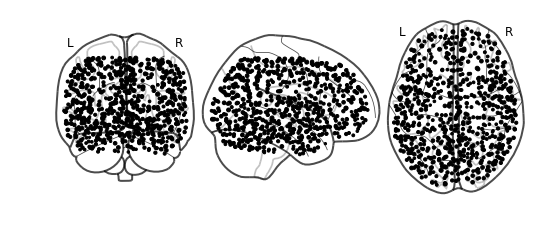

In [6]:
h = nl.plotting.plot_connectome(np.eye(centers.shape[0]), centers, node_color='k', node_size=(widths ** 2) / 250)
h.savefig(os.path.join(figdir, 'nodes.png'))

In [7]:
def mlab_array(x):
    return matlab.double(x.tolist())

In [8]:
def BrainNet_animation(centers, widths, connections, outfile, ts=None, limit_t=None, force_refresh=False):
    if ts is None:
        ts = np.arange(connections.shape[2])
    
    if not (limit_t is None):
        inds = (ts >= np.min(limit_t)) & (ts <= np.max(limit_t))
    else:
        inds = np.ones(ts.shape[0]) > 0
    
    ts = ts[inds]
    connections = connections[:, :, inds]
    
    for i, t in enumerate(ts):
        if ts.shape[0] > 1:
            next_fname = outfile + '_' + '{:03d}'.format(i) + '.jpg'
        else:
            next_fname = outfile + '.jpg'
        if (not os.path.exists(next_fname)) or force_refresh:
            eng.TFA_BrainNet_wrapper(mlab_array(centers), mlab_array(widths), mlab_array(np.squeeze(connections[:, :, i])), next_fname, 'brainnet_config.mat', nargout=0)                                            

In [9]:
eng = mlab.start_matlab()

## Plot average correlations:

In [19]:
levels = np.arange(0,16,1)
conditions = ['intact', 'paragraph', 'rest', 'word']

In [20]:
data_dir = os.path.join(results_dir, 'mean_corrs')
corrs_dir = os.path.join(data_dir, 'corrs')

In [22]:
percent_thresh = .5

for l in levels:
    for c in conditions:
        conds = glob.glob(os.path.join(data_dir, f'level_{l}', f'{c}.npy'))
        g_try = np.load(conds[0])
        g_m = np.mean(g_try[:, :, :9], axis=2)
        g_m = np.load(conds[0])
        next_figdir = os.path.join(figdir, 'corrs', 'mean_corrs', f'level_{l}', f'mean')
        if not os.path.exists(next_figdir):
            os.makedirs(next_figdir)
        
        networks = copy.copy(g_m)
        networks = networks[:,:, np.newaxis]
        thresh_inds = np.logical_or(networks >= np.percentile(g_m, 100-percent_thresh), networks <= np.percentile(g_m, percent_thresh))
        networks[~thresh_inds] = 0
        BrainNet_animation(centers, widths, networks, os.path.join(next_figdir, c), force_refresh=True)

['/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/mean_corrs/level_1/word.npy']
['/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/mean_corrs/level_15/word.npy']


## Plot slices every nth correlation:

In [89]:
data_dir = os.path.join(results_dir, 'sliced_corrs')
corrs_dir = os.path.join(data_dir, 'corrs')

In [108]:
percent_thresh = .25

for l in levels:
    for c in conditions:
        
        conds = glob.glob(os.path.join(data_dir, f'level_{l}', f'{c}.npy'))
        print(conds)
        g_m = np.load(conds[0])
        
        next_figdir = os.path.join(figdir, 'corrs', 'sliced_corrs', f'level_{l}', f'mean')
        if not os.path.exists(next_figdir):
            os.makedirs(next_figdir)
        networks = copy.copy(g_m)
        thresh_inds = np.logical_or(networks >= np.percentile(g_m, 100-percent_thresh), networks <= np.percentile(g_m, percent_thresh))
        networks[~thresh_inds] = 0
        BrainNet_animation(centers, widths, networks, os.path.join(next_figdir, c), force_refresh=True)

        

['/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/results/sliced_corrs/level_1/rest.npy']


MatlabExecutionError: 
  File /Applications/MATLAB_R2018b.app/toolbox/matlab/graphics/+matlab/+hg/+internal/openfigLegacy.m, line 117, in openfigLegacy

  File /Applications/MATLAB_R2018b.app/toolbox/matlab/guide/gui_mainfcn.m, line 286, in local_openfig

  File /Applications/MATLAB_R2018b.app/toolbox/matlab/guide/gui_mainfcn.m, line 158, in gui_mainfcn

  File /Users/lucyowen/Desktop/Jeremy_code/BrainNet_code/hierarchical-topographic-factor-analysis/dependencies/BrainNetViewer/BrainNet.m, line 51, in BrainNet

  File /Users/lucyowen/Desktop/Jeremy_code/BrainNet_code/hierarchical-topographic-factor-analysis/dependencies/BrainNetViewer/BrainNet_MapCfg.m, line 73, in BrainNet_MapCfg

  File /Users/lucyowen/Desktop/Jeremy_code/BrainNet_code/hierarchical-topographic-factor-analysis/plotting/TFA_BrainNet_wrapper.m, line 32, in TFA_BrainNet_wrapper
Invalid or deleted object.


In [ ]:
eng.exit()